# Talktorial 11 (part C)

# CADD web services that can be used via a Python API

__Developed at AG Volkamer, Charité__

Dr. Jaime Rodríguez-Guerra, Dominique Sydow

## Aim of this talktorial

> This is part C of the "Online webservices" talktorial:
>
> - 11a. Querying KLIFS & PubChem for potential kinase inhibitors
> - 11b. Docking the candidates against the target obtained in 11a
> - __11c. Assessing the results and comparing against known data__

After obtaining input structures and docking them, we will assess whether the results are any good.

## Learning goals

### Theory

- Protein-ligand interactions
- False positives in docking

### Practical

- Visualize the results
- Run automated analysis


## References

- Du, X.; Li, Y.; Xia, Y.-L.; Ai, S.-M.; Liang, J.; Sang, P.; Ji, X.-L.; Liu, S.-Q. Insights into Protein–Ligand Interactions: Mechanisms, Models, and Methods. Int. J. Mol. Sci. 2016, 17, 144. DOI: 10.3390/ijms17020144 
- Ferreira de Freitasa, R.; Schapira, M. Med. Chem. Commun., 2017,8, 1970-1981. DOI: 10.1039/C7MD00381A
- Klebe G. (2013) Protein–Ligand Interactions as the Basis for Drug Action. In: Klebe G. (eds) Drug Design. Springer, Berlin, Heidelberg. DOI: 10.1007/978-3-642-17907-5_4
- Salentin,S. et al. PLIP: fully automated protein-ligand interaction profiler. Nucl. Acids Res. (1 July 2015) 43 (W1): W443-W447. doi: 10.1093/nar/gkv315

***

## Theory

### Protein-ligand interactions

Ligand binding is mainly governed by noncovalent interactions between the ligand and the surface of the protein pocket or protein-protein interface. This process is a function of electrostatic and shape complementarities, induced fitting, desolvation processes and more.

Some quotes from the literature:

Adapted from [José L. Medina-Franco, Oscar Méndez-Lucio, Karina Martinez-Mayorga](https://www.sciencedirect.com/science/article/pii/S1876162314000029):

> Understanding protein–ligand interactions (PLIs) and protein–protein interactions (PPIs) is at the core of molecular recognition and has a fundamental role in many scientific areas. PLIs and PPIs have a broad area of practical applications in drug discovery including but not limited to molecular docking, structure-based design, virtual screening of molecular fragments, small molecules, and other type of compounds, clustering of complexes, and structural interpretation of activity cliffs, to name a few.

Of course, these interactions can be rationalized in several ways, which opens the door to systematic analysis of the docking solutions. For example, as adapted from [Med. Chem. Commun., 2017,8, 1970-1981](https://pubs.rsc.org/en/content/articlelanding/2017/md/c7md00381a#!divAbstract):

> We extracted from the PDB all X-ray structures of small-molecules in complex with proteins, with a resolution ≤2.5 Å, resulting in a collection of 11,016 complexes. To be considered as a ligand, the compound had to meet several criteria such as being a small molecule and be of interest for medicinal chemistry applications (buffers or part of crystallization cocktails were excluded). This collection contained 750,873 ligand–protein atom pairs, where a pair of atoms is defined as two atoms separated by 4 Å or less. The top-100 most frequent ligand–protein atom pairs can be clustered into seven interaction types (see figure below). Among the most frequently observed are interactions that are well known and widely used in ligand design such as hydrophobic contacts, hydrogen bonds and π-stacking. These are followed by weak hydrogen bonds, salt bridges, amide stacking, and cation–π interactions.

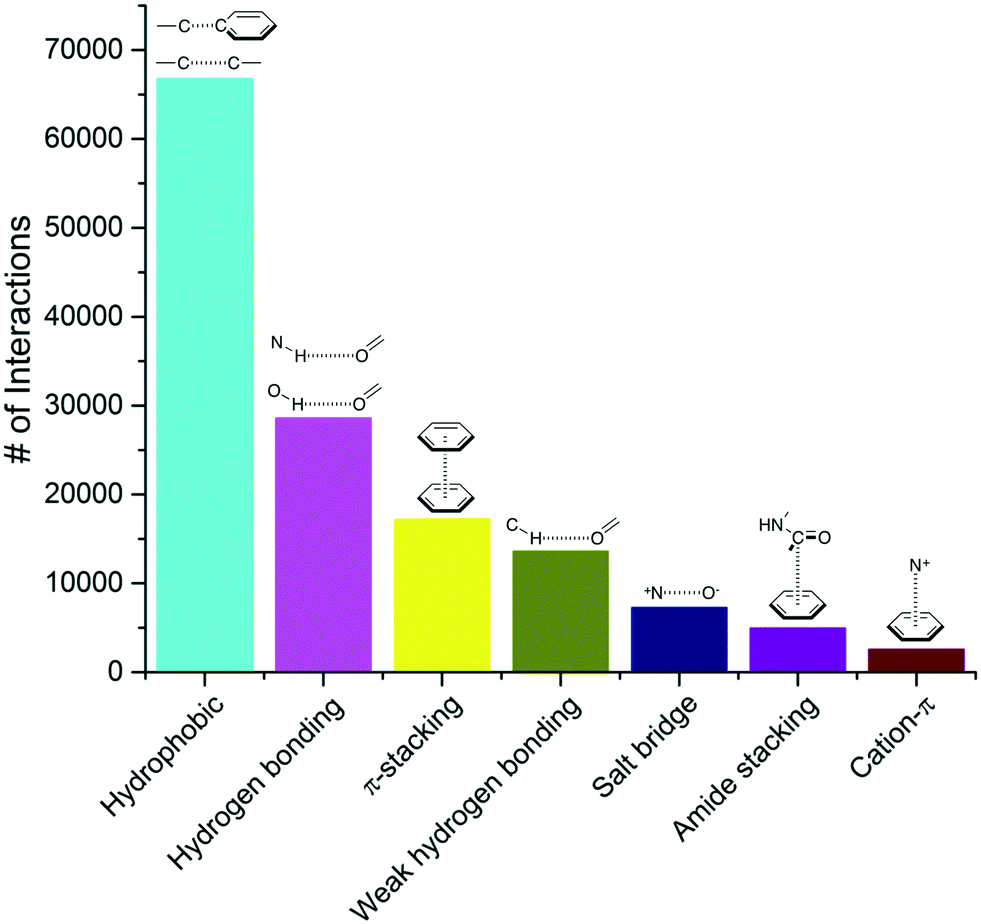

There are several programs to assess protein-ligand interactions in an automated way. [PLIP](https://plip.biotec.tu-dresden.de/plip-web/plip/index) is one of the most popular thanks to is publicly available webserver and free-to-use Python library. The [supporting information](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489249/bin/supp_gkv315_nar-00254-web-b-2015-File003.pdf) accompanying the manuscript describes protein-ligand interactions in a simple way that is very easy to understand:

In [1]:
# You might need to click "File> Trust this notebook for this live PDF preview to work"
import requests
from IPython.display import HTML
pdf = "https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4489249/bin/supp_gkv315_nar-00254-web-b-2015-File003.pdf"
display(HTML(f"""
<iframe src="https://docs.google.com/viewer?url={pdf}&embedded=true"
     frameborder="0" webkitallowfullscreen mozallowfullscreen 
     allowfullscreen width="900" height="600">
</iframe>
"""))

### False positives

Docking software does not provide definitive answers! All solutions must be examined rigorously. For example, in this review, [L.Yang, J.Zhang, X.Che, Y.Q.Gao, in Methods in Enzymology, 2016](https://www.sciencedirect.com/science/article/pii/S0076687916300660) point out that:

> In the study of protein–ligand interactions, the flexibility of a ligand could also play an important rule. However, only a limited number of conformations are usually considered in studies of ligand/protein interactions. On the other hand, a growing number of examples show that a thorough study of the ligand conformation ensemble is vital to investigate and predict ligand/substrate–protein interactions. Moreover, in structure-based drug design, the tested conformations of ligands are the foundation for subsequent calculations. Particularly, a ligand can adopt quite different conformations before and after it binds to the effector protein, and evidence exists to show that many ligands do not bind to the proteins through their local minimum energy conformation. In such cases, inadequate analysis of the free ligand conformation may result in wrong binding free energy prediction and could be potentially problematic when further enzymatic reaction is involved. Therefore, a thorough sampling of solution structures of the free ligands becomes necessary, which can be realized cost effectively by MD simulations combined with proper enhanced sampling methods.

This is only one of the possible failure points.

***

## Practical

### Visualize the results

Use `nglview` for that! It's a web-based molecular viewer that can be run on Jupyter Notebooks! Also, it's compatible with `PDBQT` files out of the box (but will only load the first model... we will see how to deal with that).

To install `nglview` run:

We will use `ipywidgets` to create an interactive GUI in the notebook. That way, we can click on the different ligands and the viewer will be refreshed accordingly. In particular, we want our little GUI to:

- Show the list of poses and their affinities, as reported in the Vina output
- Show the protein structure with a ribbon representation, the ligand with ball and stick, and the surrounding residues with licorice (stick-only)
- The 3D visualization should respond to the user selecting a different pose in the list

So, this means that we need to:

1. Invoke the NGL viewer with the adequate representations
2. Build an interactive table of results (hint: use `ipywidgets.Select`)
3. Write an event handler that can communicate with the NGL Viewer: when the user clicks on a new entry, update the ligand in display, along with the surrounding residues (the ribbon should not need to be updated)

In [2]:
import pandas as pd
import time
import nglview as nv
# ipywidgets must be v7.5+ to provide AppLayout
from ipywidgets import AppLayout, Layout, Select

_ColormakerRegistry()

The PDBQT file created by Vina contains several models, but `nglview` will only parse the first one. The workaround is simple: divide the file into individual models by splitting whenever an `ENDMDL` line is found.

In [3]:
def split_pdbqt(path):
    """
    Split a multimodel PDBQT into separate files.
    """
    files = []
    with open(path) as f:
        lines = []
        i = 0
        for line in f:
            lines.append(line)
            if line.strip() == 'ENDMDL':
                fn = f'data/results.{i}.pdbqt'
                with open(fn, 'w') as o:
                    o.write(''.join(lines))
                files.append(fn)
                i += 1
                lines = []
    return files

The Vina output is a simple text file that contains the table of results. Parsing that table is relatively straightforward. We return a `pandas.DataFrame` for a simple visualization, if needed.

In [4]:
def parse_output(out):
    """
    Create a DataFrame out of the Vina output file
    """
    with open(out) as f:
        data = []
        for line in f:
            if line.startswith('-----+'):
                line = next(f)
                while line.split()[0].isdigit():
                    index, *floats = line.split()
                    data.append([int(index)] + list(map(float, floats)))
                    line = next(f)
    return pd.DataFrame.from_records(data, 
                                     columns=['Mode', 'Affinity (kcal/mol)', 'RMSD (l.b.)', 'RMSD (u.b.)'], 
                                     exclude=['Mode'])

With this function we can convert this text file:

In [5]:
!cat data/vina.out

#################################################################
# If you used AutoDock Vina in your work, please cite:          #
#                                                               #
# O. Trott, A. J. Olson,                                        #
# AutoDock Vina: improving the speed and accuracy of docking    #
# with a new scoring function, efficient optimization and       #
# multithreading, Journal of Computational Chemistry 31 (2010)  #
# 455-461                                                       #
#                                                               #
# DOI 10.1002/jcc.21334                                         #
#                                                               #
# Please see http://vina.scripps.edu for more information.      #
#################################################################

Reading input ... done.
Setting up the scoring function ... done.
Analyzing the binding site ... done.
Using random seed: 1192913347
Performi

... into this nicely formatted `pandas.DataFrame`:

In [6]:
parse_output("data/vina.out")

,Affinity (kcal/mol),RMSD (l.b.),RMSD (u.b.)
0,-8.4,0.000,0.000
1,-6.6,5.208,9.152


The Vina output contains three columns:

1. The estimated binding affinity
2. RMSD with respect to the best solution (lowest affinity) using a symmetry-corrected algorithm
3. Same, but without the symmetry correction

We are only interested in the affinity, so in the following cells you will see that we only get a single column for that `pandas.DataFrame`.

***

Now we create the NGL viewer instance. Instead of creating a new one for each protein-pose pair, we will reuse the same canvas all over, hiding or showing the needed ligands. We will load everything first, while also labeling the ligands with their respective affinity. Each molecule loaded into the viewer is called a "component". The protein will be loaded first, so it will be `component_0`. Ligands will follow starting with `component_1` and so on.

In [7]:
def create_viewer(protein, ligands, affinities):
    """
    Create a nglview widget with the protein and all the ligands labeled by affinities
    """
    viewer = nv.show_file(protein)
    # Select first atom in molecule (@0) so it holds the affinity label
    label_kwargs = dict(labelType="text", sele="@0", showBackground=True, backgroundColor="black")
    for ligand, affinity in zip(ligands, affinities):
        ngl_ligand = viewer.add_component(ligand, ext="pdbqt")
        ngl_ligand.add_label(labelText=[str(affinity)], **label_kwargs)
    return viewer

And finally, in this cell below we will build the actual GUI!

It will be composed of two widgets arranged horizontally using the `ipywidgets.AppLayout` layour.

- The selector (`ipywidgets.Select`)
- The NGL viewer itself

When the user clicks on a new entry in the selector, `_on_selection_change` will be called, which will:

1. Check if the new value is any different from the previous one. If that's the case, then:
2. Hide all ligands (simpler way to hide the previous one; no need to check individually)
3. Show the new one and center the camera on it with a cool 500ms animation
4. Execute some JavaScript on the NGL viewer to update the list of sidechains within 5A of the new pose center of mass.

In [8]:
# JavaScript code needed to update residues around the ligand
# because this part is not exposed in the Python widget
# Based on: http://nglviewer.org/ngl/api/manual/snippets.html
_RESIDUES_AROUND = """
var protein = this.stage.compList[0];
var ligand_center = this.stage.compList[{index}].structure.atomCenter();
var around = protein.structure.getAtomSetWithinPoint(ligand_center, {radius});
var around_complete = protein.structure.getAtomSetWithinGroup(around);
var last_repr = protein.reprList[protein.reprList.length-1];
protein.removeRepresentation(last_repr);
protein.addRepresentation("licorice", {{sele: around_complete.toSeleString()}});
"""

def show_docking(protein, ligands, vina_output):
    # Split the multi PDBQT ligand file into separate files
    ligands_files = split_pdbqt(ligands)
    # Retrieve affinities (we only need that column of the dataframe)
    affinities = parse_output(vina_output)['Affinity (kcal/mol)']
                                
    # Create viewer widget
    viewer = create_viewer(protein, ligands_files, affinities)
    
    # Create selection widget
    #   Options is a list of (text, value) tuples. When we click on select, the value will be passed
    #   to the callable registered in `.observe(...)`
    selector = Select(options=[(f"#{i} {aff} kcal/mol", i) for (i, aff) in enumerate(affinities, 1)],
                      description="",  rows=len(ligands_files), layout=Layout(width="auto"))
                 
    # Arrange GUI elements
    # The selection box will be on the left, the viewer will occupy the rest of the window
    display(AppLayout(left_sidebar=selector, center=viewer, pane_widths=[1, 6, 1]))
    
    # This is the event handler - action taken when the user clicks on the selection box
    # We need to define it here so it can "see" the viewer variable
    def _on_selection_change(change):
        # Update only if the user clicked on a different entry
        if change['name'] == 'value' and (change['new'] != change['old']):
            viewer.hide(list(range(1,len(ligands_files) + 1)))  # Hide all ligands (components 1-n)
            component = getattr(viewer, f"component_{change['new']}")
            component.show()  # Display the selected one
            component.center(500)  # Zoom view
            # Call the JS code to show sidechains around ligand
            viewer._execute_js_code(_RESIDUES_AROUND.format(index=change['new'], radius=5))
    
    # Register event handler
    selector.observe(_on_selection_change)
    # Trigger event manually to focus on the first solution
    _on_selection_change({'name': 'value', 'new': 1, 'old': None})

    return viewer

In the function above we are doing some advanced Python. If you are interested, you can click on the header below to show some more details.

<br />

<details>
    
<summary>Advanced Python explanation</summary>
    
> First you might have noticed is that we are mixing JavaScript and Python code! This is possible thanks to the `ipywidgets` infrastructure, as provided in `NGLViewer.Viewer._execute_js_code`. You can pass a string here (containing JavaScript code) and it will be executed in the NGL widget scope (`this` refers to the interactive canvas). To make it parameterizable, we have added some template placeholders that are formatted on each call to `_on_selection_change`.
>
> This function, `_on_selection_change` is the glue that ties user interactions (clicks on the selection box) to the Python world. It will be called each time you click on the selection box, with a single argument `change`: a dictionary containing the type of event and both the old and new values (so you can compare and do something about it). However, we also need `viewer` to be present in that function... and [we cannot pass additional values](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Traitlet-events)!
>
> One way to have `viewer` available in that function is to nest its definition within our `show_docking` function. That way, it will be able to access the outer scope without having to look up in the notebook (global) scope. You have some [more information about scope and closures in this post](https://medium.com/@dannymcwaves/a-python-tutorial-to-understanding-scopes-and-closures-c6a3d3ba0937).

</details>



In [9]:
viewer = show_docking("data/protein.mol2", "data/results.pdbqt", "data/vina.out")

AppLayout(children=(Select(layout=Layout(grid_area='left-sidebar', width='auto'), options=(('#1 -8.4 kcal/mol'…

### Analyze the protein-ligand interactions

PLIP offers [a webserver]() for automated analysis, but unfortunately there is no API. We could try to use the HTML forms as if we were using the standard web UI, but since the library itself is Python-3 ready and very easy to install with `pip`, we can just use it locally for simplicity.

In [11]:
from plip.modules.preparation import PDBComplex
from plip.modules.report import BindingSiteReport
from glob import glob
import os
import pandas as pd

PLIP will only accept PDB files, but since PDBQT files are extended-syntax PDBs, converting from one to another is a matter of choosing the right subset of columns and records. In this case, we are only interested in `ATOM` (protein atoms) and `HETATM` (ligand atoms) records, discarding the added fields (after column `66`). Then, merging them together can be done by mere concatenation.

In [12]:
def pdbqt_to_pdbblock(pdbqt):
    lines = []
    with open(pdbqt) as f:
        for line in f:
            if line[:6] in ('ATOM  ', 'HETATM'):
                lines.append(line[:67].strip())
    return '\n'.join(lines)

def create_protein_ligand_pdbs(protein_pdbqt, ligands_pdbqt):
    ligands_pdbqt = sorted(list(glob(ligands_pdbqt)), key=lambda s: int(s.split('.')[-2]))
    protein_pdbblock = pdbqt_to_pdbblock(protein_pdbqt)
    for i, ligand_pdbqt in enumerate(ligands_pdbqt, 1):
        ligand_pdbblock = pdbqt_to_pdbblock(ligand_pdbqt)
        with open(f"data/docked_protein_ligand.{i}.pdb", 'w') as f:
            f.write(protein_pdbblock)
            f.write("COMPND    UNNAMED\n")
            f.write(ligand_pdbblock)

Tada!

In [14]:
create_protein_ligand_pdbs("data/protein.mol2.pdbqt", "data/results.*.pdbqt")

Now we can pass the PDB file to PLIP and let it do its magic. The `BindingSiteReport` class will process each detected binding site in `PDBComplex` and will create an object with the fields we are interested in:

- `hydrophobic`
- `hbond`
- `waterbridge`
- `saltbridge`
- `pistacking`
- `pication`
- `halogen`
- `metal`

These fields are divided in `<field>_features` (containing column names) and `<field>_info` (containing the actual records). If we iterate over the object retrieving the correct attribute name with `getattr()`, we can compose a dictionary that can be passed to a `pandas.DataFrame` for nice overviews. Check it below:

In [15]:
def analyze_interactions(pdbfile):
    protlig = PDBComplex()
    protlig.load_pdb(pdbfile)  # load the pdb
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas df
        keys = "hydrophobic", "hbond", "waterbridge", "saltbridge", "pistacking", "pication", "halogen", "metal"
        interactions = {k: [getattr(binding_site, k+"_features")] + getattr(binding_site, k+"_info") for k in keys}
        sites[key] = interactions
    return sites

In [16]:
interactions_by_site = analyze_interactions("data/docked_protein_ligand.1.pdb")
interactions_by_site

{'UNL:Z:1': {'hydrophobic': [('RESNR',
    'RESTYPE',
    'RESCHAIN',
    'RESNR_LIG',
    'RESTYPE_LIG',
    'RESCHAIN_LIG',
    'DIST',
    'LIGCARBONIDX',
    'PROTCARBONIDX',
    'LIGCOO',
    'PROTCOO'),
   (29,
    'VAL',
    'A',
    1,
    'UNL',
    'Z',
    '3.69',
    2837,
    273,
    (1.893, 19.854, 40.151),
    (4.46, 17.889, 41.924)),
   (46,
    'ALA',
    'A',
    1,
    'UNL',
    'Z',
    '3.92',
    2837,
    433,
    (1.893, 19.854, 40.151),
    (3.01, 21.239, 43.644)),
   (50,
    'LEU',
    'A',
    1,
    'UNL',
    'Z',
    '3.22',
    2820,
    472,
    (7.688, 20.565, 32.46),
    (9.913, 19.291, 34.416)),
   (80,
    'LEU',
    'A',
    1,
    'UNL',
    'Z',
    '3.76',
    2813,
    755,
    (4.018, 24.933, 34.469),
    (5.789, 27.133, 36.951)),
   (93,
    'THR',
    'A',
    1,
    'UNL',
    'Z',
    '3.84',
    2839,
    868,
    (2.548, 20.564, 39.182),
    (2.079, 23.846, 41.128)),
   (157,
    'THR',
    'A',
    1,
    'UNL',
    'Z',
    '3.89',
 

This dictionary is composed of two levels. First level is the detected binding sites. We should only expect one because we are only docking one ligand. For each binding site, we will have one more sub-dictionary containing eight lists, one for each specific interaction. Each list will contain the column names in the first row, and the data (if available) in the following. Knowing that, we can construct a `pandas.DataFrame` like this:

In [17]:
df = pd.DataFrame.from_records(interactions_by_site["UNL:Z:1"]["hbond"][1:], # data is stored AFTER the column names
                               columns=interactions_by_site["UNL:Z:1"]["hbond"][0]) # column names are always the first element
df

,RESNR,RESTYPE,RESCHAIN,RESNR_LIG,RESTYPE_LIG,RESCHAIN_LIG,SIDECHAIN,DIST_H-A,DIST_D-A,DON_ANGLE,PROTISDON,DONORIDX,DONORTYPE,ACCEPTORIDX,ACCEPTORTYPE,LIGCOO,PROTCOO
0,78,SER,A,1,UNL,Z,True,3.02,3.67,125.99,True,729,O3,2816,Nar,"(2.256, 22.902, 37.49)","(-1.134, 24.07, 36.708)"
1,65,GLU,A,1,UNL,Z,True,2.65,3.58,172.38,True,624,O3,2828,O3,"(5.474, 25.096, 32.607)","(6.575, 22.875, 30.023)"
2,158,ASP,A,1,UNL,Z,False,3.16,3.75,118.55,True,1510,Nam,2830,Npl,"(3.439, 20.868, 36.944)","(0.397, 20.13, 34.875)"
3,158,ASP,A,1,UNL,Z,False,3.21,3.64,106.41,False,2830,Npl,1514,O2,"(3.439, 20.868, 36.944)","(3.361, 20.558, 33.314)"


Now, let's try to represent those interactions in the NGL viewer. We can draw cylinders between the interaction points (`LIGCOO` and `PROTCOO` in the `pandas.DataFrame`), color-coding them as shown in `color_map` (uses RGB tuples).

In [18]:
color_map = {
    'hydrophobic': [0.90, 0.10, 0.29],
    'hbond': [0.26, 0.83, 0.96],
    'waterbridge': [1.00, 0.88, 0.10],
    'saltbridge': [0.67, 1.00, 0.76],
    'pistacking': [0.75, 0.94, 0.27],
    'pication': [0.27, 0.60, 0.56],
    'halogen': [0.94, 0.20, 0.90],
    'metal': [0.90, 0.75, 1.00],
}

def show_docking_and_interactions(protein, ligands, vina_output):
    # Split the multi PDBQT ligand file into separate files
    ligands_files = split_pdbqt(ligands)
    # Retrieve affinities (we only need that column of the dataframe)
    affinities = parse_output(vina_output)['Affinity (kcal/mol)']
                                
    # Create selection widget
    #   Options is a list of (text, value) tuples. When we click on select, the value will be passed
    #   to the callable registered in `.observe(...)`
    selector = Select(options=[(f"#{i} {aff} kcal/mol", i-1) for (i, aff) in enumerate(affinities, 1)],
                      description="",  rows=len(ligands_files), layout=Layout(width="auto"))
                 
    # Arrange GUI elements
    # The selection box will be on the left, the viewer will occupy the rest of the window (but it will be added later)
    app = AppLayout(left_sidebar=selector, center=None, pane_widths=[1, 6, 1])
    
    # This is the event handler - action taken when the user clicks on the selection box
    # We need to define it here so it can "see" the viewer variable
    def _on_selection_change(change):
        # Update only if the user clicked on a different entry
        if change['name'] == 'value' and (change['new'] != change['old']):
            if app.center is not None:
                app.center.close()
            app.center = viewer = nv.NGLWidget()
            viewer.add_component(protein, ext="pdbqt") # add protein
            lig_component = viewer.add_component(ligands_files[change['new']], ext="pdbqt") # add selected ligand
            # Add interactions
            interactions_by_site = analyze_interactions(f"data/docked_protein_ligand.{change['new']+1}.pdb")
            interacting_residues = []                                    
            for site, interactions in interactions_by_site.items():
                for interaction_type, interaction_list in interactions.items():
                    color = color_map[interaction_type]
                    if len(interaction_list) == 1:
                        continue
                    df_interactions = pd.DataFrame.from_records(interaction_list[1:], columns=interaction_list[0])
                    for _, interaction in df_interactions.iterrows():
                        name = (f"{interaction_type}")
                        viewer.shape.add_cylinder(interaction['LIGCOO'], interaction['PROTCOO'], color, [0.1], name) 
                        interacting_residues.append(interaction['RESNR'])
            # Display interacting residues
            viewer.component_0.add_ball_and_stick(sele=", ".join(map(str, interacting_residues)))
            viewer.component_1.center(500)  # Zoom view
                                                        
    # Register event handler
    selector.observe(_on_selection_change)
    # Trigger event manually to focus on the first solution
    _on_selection_change({'name': 'value', 'new': 1, 'old': None})

    return app


`show_docking_and_interactions` is mostly the same function as `show_docking`, but it will also calculate the PLIP interactions for each selection event. In this case, the event handler is a bit more involved. We have to recreate the NGL viewer for each selection event because the interaction cylinders cannot be manually erased. However, this time there is no JavaScript involved; just pure Python. Recreating the viewer widget from scratch, loading the molecules and calculating the interactions takes more time, though, and as a result the experience is not that dynamic.

In [19]:
show_docking_and_interactions("data/protein.mol2.pdbqt", "data/results.pdbqt", "data/vina.out")

AppLayout(children=(Select(layout=Layout(grid_area='left-sidebar', width='auto'), options=(('#1 -8.4 kcal/mol'…

## Discussion

In this last part of the talktorial we have learned how to visualize and analyze the docking results as provided by Vina. Unlike the other parts, this notebook is executed locally - there is no webserver being called. However, there is a good amount of web technologies, mainly based around the NGL viewer and `ipywidgets` layouts.

We first used event handlers (as registered by `.observe()`) to interactively update the viewer with the selected protein-ligand pose and its surroundings. Then, we extended the visualization using PLIP's automated analysis to draw the interactions in the viewer.

## Quiz

- Which kind of interaction is the most important in the observed docking analysis? Does this match the consensus in the literature? Why?
- What's the main difference between hydrophobic interactions and hydrogen bonds? How are they similar?
- Write a function to use the PLIP webserver by applying what you have learned in part B. You will need to check the HTML source code to locate the main `form` entries and their `action` endpoints, as well as any `input` tag required to submit the request.